In [1]:
dataset_name = "ec2_cpu_utilization_ac20cd"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preprocess Dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '5min', data))
ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="5min", 
                                          dateformat="%Y-%m-%d %H:%M:%S", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2014-04-15 00:49:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2014-04-02 14:29:00
End date:  2014-04-16 14:49:00
Missing time stamps: 
 DatetimeIndex(['2014-04-07 13:39:00', '2014-04-07 13:44:00',
               '2014-04-14 23:49:00', '2014-04-14 23:54:00',
               '2014-04-14 23:59:00'],
              dtype='datetime64[ns]', freq=None)
Length:  4037
Time step size:  5min
Start Date:  2014-04-02 14:29:00
End Date:  2014-04-16 14:49:00
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [3580]


# GLM

In [4]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

100%|██████████| 4032/4032 [00:00<00:00, 24026.43it/s]

Initial Mean 30.21449917355372
Initial StdDev 17.176365587345547



 43%|████▎     | 1738/4032 [00:00<00:00, 17368.05it/s]

eta:  0.5
lambda:  0.99
MSE:  2839862049691157.0
Initial Mean 30.21449917355372
Initial StdDev 17.176365587345547


100%|██████████| 4032/4032 [00:00<00:00, 22576.66it/s]

eta:  0.5
lambda:  0.999
MSE:  199.03908314719646
Initial Mean 30.21449917355372
Initial StdDev 17.176365587345547



 41%|████      | 1647/4032 [00:00<00:00, 16312.04it/s]

eta:  0.5
lambda:  0.9999
MSE:  379.96021477903787
Initial Mean 30.21449917355372
Initial StdDev 17.176365587345547


 40%|████      | 1621/4032 [00:00<00:00, 16200.94it/s]

eta:  1
lambda:  0.99
MSE:  417.7537485058445
Initial Mean 30.21449917355372
Initial StdDev 17.176365587345547


 38%|███▊      | 1523/4032 [00:00<00:00, 15226.67it/s]

eta:  1
lambda:  0.999
MSE:  101.5700441448934
Initial Mean 30.21449917355372
Initial StdDev 17.176365587345547


100%|██████████| 4032/4032 [00:00<00:00, 14918.15it/s]


eta:  1
lambda:  0.9999
MSE:  282.7926819645449

best params:  eta 1 lambda 0.999


100%|██████████| 4032/4032 [00:00<00:00, 23041.29it/s]

Initial Mean 30.21449917355372
Initial StdDev 17.176365587345547


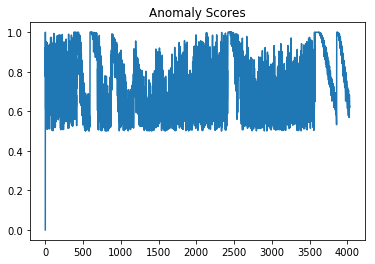

Time:  1.1712613105773926


['anomaly_scores/GLM/ec2_cpu_utilization_ac20cd_no_fill']

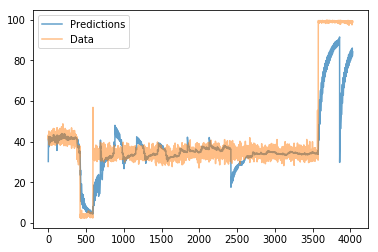

In [5]:
save_path = "anomaly_scores/GLM/" + dataset_name+ "_no_fill"
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=int(best_params[4:6]),
                     lambda_=float(best_params[14:]),
                     plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# SARIMA


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : 3917.969
 ARIMA(1,0,0) with non-zero mean : 3356.785
 ARIMA(0,0,1) with non-zero mean : 3640.644
 ARIMA(0,0,0) with zero mean     : 3917.072
 ARIMA(2,0,0) with non-zero mean : 3278.541
 ARIMA(3,0,0) with non-zero mean : 3258.483
 ARIMA(4,0,0) with non-zero mean : Inf
 ARIMA(3,0,1) with non-zero mean : Inf
 ARIMA(2,0,1) with non-zero mean : 3259.537
 ARIMA(4,0,1) with non-zero mean : 3262.328
 ARIMA(3,0,0) with zero mean     : 3257.412
 ARIMA(2,0,0) with zero mean     : 3277.17
 ARIMA(4,0,0) with zero mean     : 3259.814
 ARIMA(3,0,1) with zero mean     : 3259.433
 ARIMA(2,0,1) with zero mean     : 3258.982
 ARIMA(4,0,1) with zero mean     : 3261.232

 Now re-fitting the best model(s) without approximations...

 ARIMA(3,0,0) with zero mean     : 3257.576

 Best model: Regression with ARIMA(3,0,0) errors 



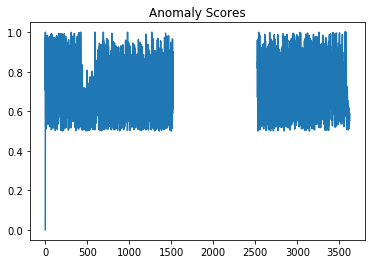

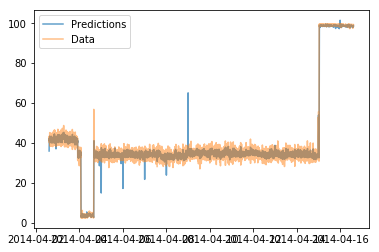

Time:  19.484111309051514


['anomaly_scores/SARIMA_auto/ec2_cpu_utilization_ac20cd_no_fill']

In [6]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name+ "_no_fill"
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Prophet

In [7]:
# optimization step

step_sizes = [100, 200]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for changepoint_prior_scale in changepoint_prior_scales:

        mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  changepoint_prior_scale=changepoint_prior_scale,
                                  step_size=step_size,
                                  optimize=True)
        print("Step Size: ", step_size)
        print("Changepoint Prior Scale: ", changepoint_prior_scale)
        print("MSE: ",mse)

        key_str = "Step Size " + str(step_size) +" Changepoint Prior Scale" + str(changepoint_prior_scale)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.01
MSE:  456.5233694745712


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.05
MSE:  169.98200924228277


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.1
MSE:  83.95171740150965


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.15
MSE:  68.97230489915171


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.2
MSE:  68.28920551254969


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.01
MSE:  456.5233694745712


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.05
MSE:  169.98200924228277


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.1
MSE:  83.95171740150965


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.15
MSE:  68.97230489915171
Step Size:  200
Changepoint Prior Scale:  0.2
MSE:  68.28920551254969

best params:  Step Size 100 Changepoint Prior Scale0.2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


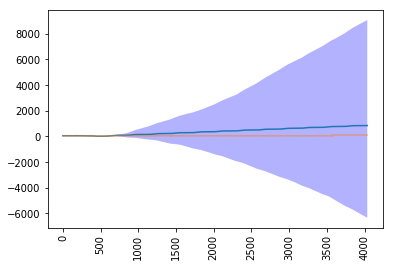

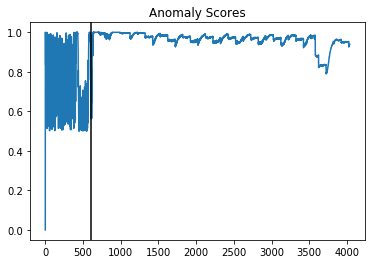

Time:  18.188947916030884


['anomaly_scores/Prophet/ec2_cpu_utilization_ac20cd_no_fill']

In [8]:
save_path = "anomaly_scores/Prophet/" + dataset_name+ "_no_fill"
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  changepoint_prior_scale=.2,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

In [9]:
# no seasonality. cannot use stl